# N-Body Physics Simulation

## Theoretical Background

### Newton's Law of Universal Gravitation
The force between two point masses $m_i$ and $m_j$ is given by:
$$ \vec{F}_{ij} = G \frac{m_i m_j}{|\vec{r}_{ij}|^3} \vec{r}_{ij} $$
where $\vec{r}_{ij} = \vec{r}_j - \vec{r}_i$ is the vector from body $i$ to body $j$.

### Equations of Motion
For a system of $N$ bodies, the acceleration of the $i$-th body is the sum of gravitational forces from all other bodies:
$$ \ddot{\vec{r}}_i = \sum_{j \neq i} G \frac{m_j}{|\vec{r}_{ij}|^3} \vec{r}_{ij} $$

### Numerical Integration
We use the **DOP853** algorithm (an explicit Runge-Kutta method of order 8(5,3)) from `scipy.integrate.solve_ivp` to solve these differential equations. This method provides high accuracy and adaptive step sizing, which is crucial for capturing the dynamics of N-body systems over long periods.

### Conservation Laws
A correct physical simulation must conserve:
1.  **Total Energy ($E$)**: $E = T + U = \text{const}$
    *   Kinetic Energy ($T$): $T = \frac{1}{2} \sum_i m_i v_i^2$
    *   Potential Energy ($U$): $U = - \frac{1}{2} \sum_{i \neq j} G \frac{m_i m_j}{|\vec{r}_{ij}|}$
2.  **Linear Momentum ($\vec{P}$)**: $\vec{P} = \sum_i m_i \vec{v}_i = \text{const}$
3.  **Angular Momentum ($\vec{L}$)**: $\vec{L} = \sum_i m_i (\vec{r}_i \times \vec{v}_i) = \text{const}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from physics_engine import PhysicsEngine

# Configuration
G = 6.67430e-11
N = 3  # Number of bodies
units = 'SI'

# Time settings
year_seconds = 365.25 * 24 * 3600
t_end = 2 * year_seconds  # Simulate for 2 years
t_points = 1000
t_span = (0, t_end)
t_eval = np.linspace(0, t_end, t_points)

# Initial Conditions (Random but scaled for visibility)
np.random.seed(42) # Reproducibility
pos0 = (np.random.rand(N, 3) - 0.5) * 2 * 1.5e11 
vel0 = (np.random.rand(N, 3) - 0.5) * 2 * 30000
masses = np.random.rand(N) * 1.989e30

# Combine into state vector
state = np.hstack((pos0.flatten(), vel0.flatten()))

# Initialize Physics Engine
engine = PhysicsEngine(units=units)

# Run Simulation
print("Running simulation...")
sol = engine.run_simulation(state, t_span, masses, t_eval=t_eval)
print("Simulation complete.")


Running simulation...
Simulation complete.


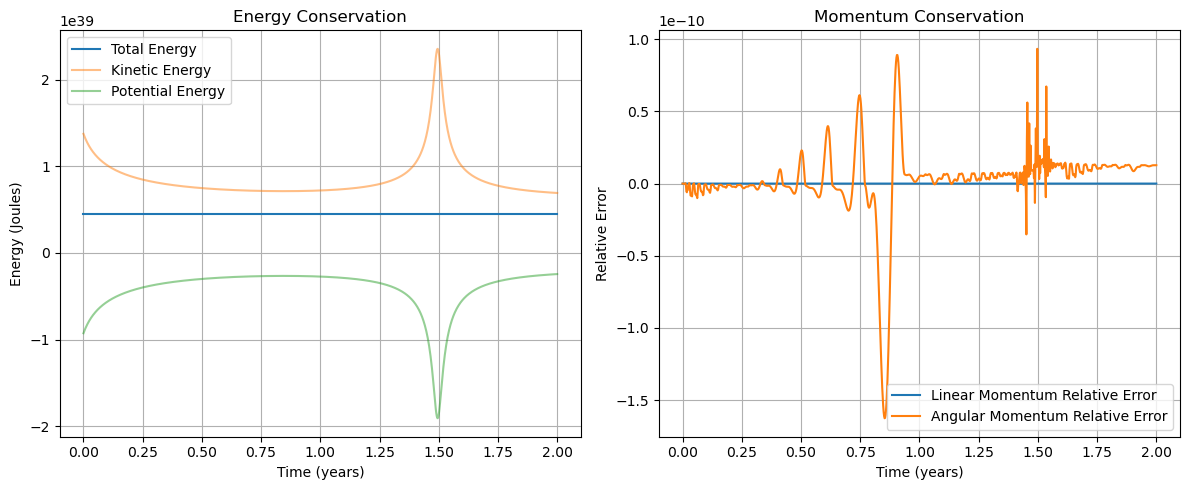

In [2]:
# Analysis: Energy and Momentum
positions = sol.y[:3*N].T.reshape(-1, N, 3)
velocities = sol.y[3*N:].T.reshape(-1, N, 3)

kinetic_energies = []
potential_energies = []
total_energies = []
linear_momenta = []
angular_momenta = []

for i in range(len(t_eval)):
    # Energy
    ke = engine._calculate_kinetic_energy(masses, velocities[i].flatten())
    pe = engine._calculate_potential_energy(masses, positions[i].flatten())
    kinetic_energies.append(ke)
    potential_energies.append(pe)
    total_energies.append(ke + pe)
    
    # Momentum
    P = np.zeros(3)
    L = np.zeros(3)
    for j in range(N):
        P += masses[j] * velocities[i, j]
        L += np.cross(positions[i, j], masses[j] * velocities[i, j])
    linear_momenta.append(np.linalg.norm(P))
    angular_momenta.append(np.linalg.norm(L))

# Plotting Energy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t_eval/year_seconds, total_energies, label='Total Energy')
plt.plot(t_eval/year_seconds, kinetic_energies, label='Kinetic Energy', alpha=0.5)
plt.plot(t_eval/year_seconds, potential_energies, label='Potential Energy', alpha=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Energy (Joules)')
plt.title('Energy Conservation')
plt.legend()
plt.grid(True)

# Plotting Momentum Conservation (Deviation)
plt.subplot(1, 2, 2)
plt.plot(t_eval/year_seconds, (np.array(linear_momenta) - linear_momenta[0])/linear_momenta[0], label='Linear Momentum Relative Error')
plt.plot(t_eval/year_seconds, (np.array(angular_momenta) - angular_momenta[0])/angular_momenta[0], label='Angular Momentum Relative Error')
plt.xlabel('Time (years)')
plt.ylabel('Relative Error')
plt.title('Momentum Conservation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


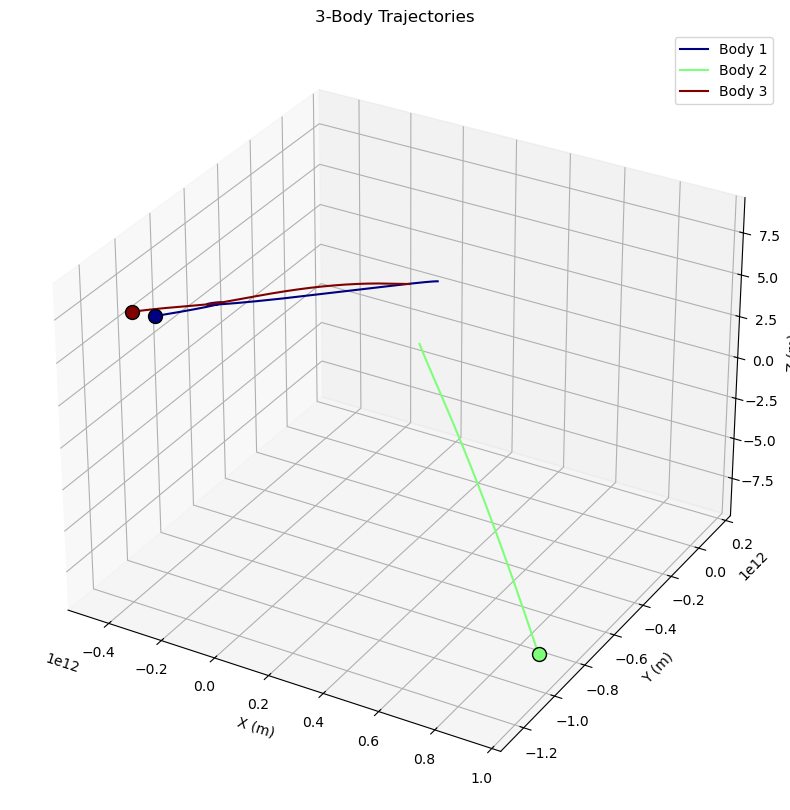

In [3]:
# 3D Trajectory Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.jet(np.linspace(0, 1, N))

for i in range(N):
    ax.plot(positions[:, i, 0], positions[:, i, 1], positions[:, i, 2],
            color=colors[i], linewidth=1.5, label=f'Body {i+1}')
    ax.scatter(positions[-1, i, 0], positions[-1, i, 1], positions[-1, i, 2],
               color=colors[i], s=100, marker='o', edgecolors='black')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title(f'{N}-Body Trajectories')
ax.legend()
plt.show()
